# Libraries

Import packages



In [ ]:
import matplotlib.pyplot as plt 
import cv2
import os
import time
import datetime
import dlib
import random

# standard libraries
import pandas as pd
import numpy as np
import operator
import pathlib

# visualizations
from IPython.display import Image
%matplotlib inline

# individual classifiers/ clustering
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN 
from google.colab.patches import cv2_imshow

#Dataset

Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Import and uncompress zipfile of image data

In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/281/Archive.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/fer2013")

!unzip /content/drive/MyDrive/281/Archive.zip

##Reading images from the Dataset

We will be working with the open source Facial Images dataset, available on kaggle.com

https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset

Read images from all 7 classes of images. Use existing split of Train and Test data

#Exploratory Data Analysis (EDA)

In this section of the python notebook, we will analyze the images in each class and identify non-facial images and duplicates in each class as well as images that are cross labelled across classes.

In [ ]:
# Data is under ./dataset/
# Set the path for the data loading
train_dir = './train/'
test_dir = './test/'

# Each image has 48x48 pixels
row, col = 48, 48
# 7 categories are under the dataset
classes = 7

# define a function for counting the number of images under the path and return a dataframe
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')

display(train_count)

display(test_count)

fear   sad  happy  angry  surprise  neutral  disgust
train  4097  4830   7215   3995      3171     4965      436

fear   sad  happy  angry  surprise  neutral  disgust
test  1024  1247   1774    958       831     1233      111

###Bar chart - Total per Class

<function matplotlib.pyplot.show(*args, **kw)>

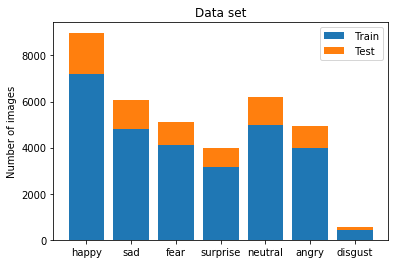

In [ ]:
## Bar chart for how many data exists for each category in 'train' and 'test'
x = ['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']
fig, ax = plt.subplots()
ax.bar(x,train_count[x].loc['train'], width=0.8, label=' Train' )
ax.bar(x,test_count[x].loc['test']  , width=0.8, bottom=train_count[x].loc['train'], label=' Test' )
ax.set_ylabel('Number of images')
ax.set_title('Data set')
ax.legend()
plt.show

In [ ]:
# The data set consist of 80% of train data and 20% of test data
df = 0
df = pd.DataFrame()
df = train_count[x].append(test_count)
df.loc['total'] = df.sum()
df

happy   sad  fear  surprise  neutral  angry  disgust
train   7215  4830  4097      3171     4965   3995      436
test    1774  1247  1024       831     1233    958      111
total   8989  6077  5121      4002     6198   4953      547

In [ ]:
# Define a function for loading data
def load_exp(path, train_only = 0):
    '''Data loading function
        X: Image data (flattened 48x48 matrix)
        Y: Label of the data (expression category)
        Z: Saving path and filename
    '''
    Y = list() 
    Z = list()  
    emotion = []
    if train_only == 0:  # 1/2 options for loading 1)both 'train' and 'test'(Non-zero value)
        set_names = ['test','train']
        train_dir = path + 'train/'
        test_dir  = path + 'test/'
        #print( train_dir)
        num = count_exp(train_dir, 'train').loc['train'].sum() + count_exp(test_dir, 'test').loc['test'].sum() 
        # number of total files under the path
        X = np.zeros((num,48*48)) # Define X for saving image data with size calculated 1 line above
    else:                # 2/2 options for loading 2)'train' only(0) 
        set_names = ['train']
        train_dir = path + 'train/'
        num = count_exp(train_dir, 'train').loc['train'].sum() # number of total files under the path
        X = np.zeros((int(num),48*48))
    
    i=0
    #print(set_names)
    for set_name in set_names:
        for expression in os.listdir(path+'/'+set_name):
            dir_ = path +set_name+'/'+ expression
            print(dir_) # print where the data is loading from
            for file in os.listdir(dir_):
                #print(dir_+'/'+file)
                X[i,:] = cv2.imread(dir_+'/'+file)[:,:,0].flatten()
                Y.append(expression)
                i += 1
                Z.append(set_name+'/'+ expression+'/' +file)
            
    return X,Y,Z

X,Y,Z = load_exp('./',0)


./test/fear
./test/sad
./test/happy
./test/angry
./test/surprise
./test/neutral
./test/disgust
./train/fear
./train/sad
./train/happy
./train/angry
./train/surprise
./train/neutral
./train/disgust


In [ ]:
#X: Image data (flattened 48x48 matrix)
#Y: Label of the data (expression category)
#Z: Saving path and filename
print(X.shape)
print(len(Y))
print(len(Z))

(35887, 2304)
35887
35887


In [ ]:
# Define a function to create sets for each category of images
def create_category_sets():
    # Separate each data set by label
    # happy sets
    happy_set = X[[i for i, expression in enumerate(Y) if expression =='happy']]
    print("happy_set",happy_set.shape)

    # sad sets
    sad_set = X[[i for i, expression in enumerate(Y) if expression =='sad']]
    print("sad_set", sad_set.shape)

    # fear sets
    fear_set = X[[i for i, expression in enumerate(Y) if expression =='fear']]
    print("fear_set", fear_set.shape)

    # surprise sets
    surprise_set = X[[i for i, expression in enumerate(Y) if expression =='surprise']]
    print("surprise_set", surprise_set.shape)

    # neutral sets
    neutral_set = X[[i for i, expression in enumerate(Y) if expression =='neutral']]
    print("neutral_set", neutral_set.shape)

    # angry sets
    angry_set = X[[i for i, expression in enumerate(Y) if expression =='angry']]
    print("angry_set", angry_set.shape)

    # disgust sets
    disgust_set = X[[i for i, expression in enumerate(Y) if expression =='disgust']]
    print("disgust_set", disgust_set.shape)

    return happy_set, sad_set, fear_set, surprise_set, neutral_set, angry_set, disgust_set

happy_set, sad_set, fear_set, surprise_set, neutral_set, angry_set, disgust_set = create_category_sets()

happy_set (8989, 2304)
sad_set (6077, 2304)
fear_set (5121, 2304)
surprise_set (4002, 2304)
neutral_set (6198, 2304)
angry_set (4953, 2304)
disgust_set (547, 2304)


**Non-facial image labeling**<br>
Manually label Non-facial images in Angry_set. Use these small data set for teach KNN model and detect Non-facial images from whole data set.

In [ ]:
## Manually went through 'Angry set' to find Non-facial images
def manually_identify_non_facial_img():

    ## Label Non-facial images
    angry_path = [i for i, expression in enumerate(Y) if expression =='angry']

    nf_cartoon = ['Training_17114283.jpg',
#                  'Training_17682275.jpg',
                  'Training_17526342.jpg',
                  'Training_19970288.jpg',
#                 'Training_20398356.jpg',
#                  'Training_21450179.jpg',
                  'Training_26852211.jpg',
                  'Training_35803006.jpg',
#                  'Training_37257754.jpg',
                  'Training_43390138.jpg',
                  'Training_48839755.jpg',
#                  'Training_50394577.jpg',
                  'Training_51191080.jpg',
                  'Training_52524029.jpg',
                  'Training_54890912.jpg',
                  'Training_72845195.jpg',
 #                 'Training_77373648.jpg', #- non facial
                  'Training_79768506.jpg',
                  'Training_80209767.jpg',
                  'Training_88679295.jpg',
                  'Training_89083007.jpg',
                  'Training_91530441.jpg',
                  'Training_94330147.jpg',
                  'Training_94204100.jpg',
                  'Training_96216570.jpg',
                  'Training_98835403.jpg',
                  'PrivateTest_17952984.jpg',
                  'PrivateTest_11296953.jpg',
                  'PrivateTest_48897228.jpg',
                  'PrivateTest_62397768.jpg',
                  'PrivateTest_61118112.jpg',
                  'PrivateTest_73170949.jpg',
                  'PrivateTest_97227751.jpg',
                  'PublicTest_18467095.jpg',
                  'PublicTest_57272892.jpg',
                  'PublicTest_88085937.jpg',
                  'Training_58634894.jpg']

    nf_black = ['PublicTest_5543497',  #black
                'Training_5645946',  #black
                'Training_10131352', #black
                'Training_25739285', #black
                'Training_28756096', #black
                'Training_32571770', #black
                'Training_52563817', #black
                'Training_78540321', #black
                'Training_96772745', #black
                'Training_99531165']

    nf_letters = ['PrivateTest_26784100', #letter
                'Training_67604214', #letter
                'Training_87875595', #letter
                'Training_93307158', #letter
                'Training_67604214.jpg']

    nf_loading = ['Training_22407840', #loading
                  'Training_84260061']

    return angry_path,  nf_black, nf_letters, nf_loading, nf_cartoon

In [ ]:
def create_labels_non_facial_img_angry_dataset():
    black = []
    letters = []
    loading = []
    cartoon = []

    angry_path, nf_black, nf_letters, nf_loading, nf_cartoon = manually_identify_non_facial_img()

    # Find indices for each non-facial images in the angry category
    for i in range(angry_set.shape[0]):
        if any(file in Z[angry_path[i]] for file in nf_black):
            black.append(i)
        elif any(file in Z[angry_path[i]] for file in nf_letters):
            letters.append(i)
        elif any(file in Z[angry_path[i]] for file in nf_loading):
            loading.append(i)
        elif any(file in Z[angry_path[i]] for file in nf_cartoon):
            cartoon.append(i)
              
    # Print indices of each category
    print("Letters",letters)
    print("Black", black)
    print("Loading", loading)
    print("Cartoon", cartoon)

    # letters = [955, 1769, 2354, 4453]
    # black = [61, 1044, 1474, 1498, 2020, 2418, 2543, 2733, 3626, 4173]
    # loading = [1849, 4461]
    # cartoon

    # Merge above labels into 'angry_label'
    angry_label =[]
    for i in range(angry_set.shape[0]):
        
        if i in black:
            angry_label.append('black')
            #print(i)
        elif i in letters:
            angry_label.append('letters')
        elif i in loading:
            angry_label.append('loading')
        elif i in cartoon:
            angry_label.append('cartoon')
        else:
            angry_label.append('face')
    return angry_label, black, letters, loading, cartoon

angry_label, black, letters, loading, cartoon = create_labels_non_facial_img_angry_dataset()

len(angry_label)


Letters [37, 2493, 3325, 4280]
Black [886, 1092, 2275, 2696, 2698, 3207, 3315, 3338, 3688, 4300]
Loading [2349, 4143]
Cartoon [41, 100, 259, 398, 410, 424, 540, 627, 790, 905, 1410, 1832, 1853, 1871, 1898, 2346, 2617, 2630, 2712, 2735, 3048, 3144, 3172, 3399, 3617, 3634, 4030, 4257, 4566, 4927, 4936]


4953

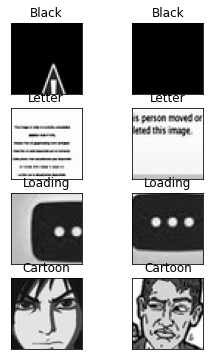

In [ ]:
# Print examples of 3 categories Non-facial images
plt.rc('image', cmap='gray')
plt.figure(figsize=(4, 6))
for i in range(8):
    
    plt.subplot(4,2,i+1)
    ax=plt.gca()
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if i < 2:
        plt.imshow(angry_set[black[i+2],:].reshape(48,48))
        ax.set_title('Black')
    elif i < 4:
        plt.imshow(angry_set[letters[i-2],:].reshape(48,48))
        ax.set_title('Letter')
    elif i < 6:
        plt.imshow(angry_set[loading[i-4],:].reshape(48,48))
        ax.set_title('Loading')
    elif i < 8:
        plt.imshow(angry_set[cartoon[i-6],:].reshape(48,48))
        ax.set_title('Cartoon')        

###Non-facial Image Detection

####Loading Image detection
Using KNN for histogram of images

In [ ]:
## Convert images to histogram
## define histogram variables for 'Angry_set', and 'X'(Whole dataset)
def convert_img_histograms():
    ang_hist = np.empty((angry_set.shape[0], len(np.arange(256))))
    X_hist = np.empty((X.shape[0], len(np.arange(256))))

    ## Convert images to histogram
    for i in range(angry_set.shape[0]):
        ang_hist[i,:] = np.histogram(angry_set[i,:], bins = np.arange(257))[0]
        
    for i in range(X.shape[0]):
        X_hist[i,:] = np.histogram(X[i,:], bins = np.arange(257))[0]

    return ang_hist, X_hist

ang_hist, X_hist = convert_img_histograms()

In [ ]:
# Check if histograms were generated
print(ang_hist.shape)
print(X_hist.shape)

(4953, 256)
(35887, 256)


**Observations**  
Histogram of images: <br>
1) Regular facial images have widely distributed histogram<br>
2) Black images have mostly black(0) and very little other tones<br>
3) Letter images have mostly white(255) and very little other tones<br>
4) Loading images have mostly bimodal distribution (some grays and some blacks <br>
5) Cartoon images have a wide distribution but not as wide as facial images


[64, 2696, 2493, 4143, 100]

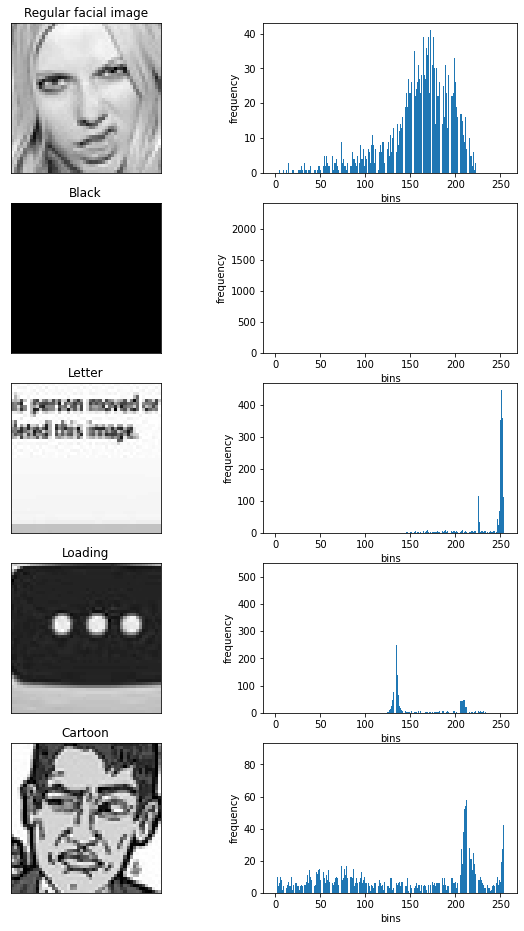

In [ ]:
hist_example = [64, black[3], letters[1], loading[1], cartoon[1]]
display(hist_example)
plt.rc('image', cmap='gray')
plt.figure(figsize=(10, 16))

for i in range(5):    
    ax = plt.subplot(5, 2,2*i+1)
    #ax.set_title('raw img')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(angry_set[hist_example[i],:].reshape(48,48))

    ax2 = plt.subplot(5,2,2*i+2)
    ax2.bar(range(256),ang_hist[hist_example[i],:])
    #ax2.set_title('histogram')
    ax2.set_ylabel('frequency')
    ax2.set_xlabel('bins')
    if i ==0:
        ax.set_title('Regular facial image')
    elif i == 1:
        ax.set_title('Black')
    elif i == 2:
        ax.set_title('Letter')
    elif i == 3:
        ax.set_title('Loading')
    elif i == 4:
        ax.set_title('Cartoon')

Training and predict images

In [ ]:
hist_filt = KNeighborsClassifier(n_neighbors=1)
hist_filt.fit(ang_hist, angry_label)
prediction = hist_filt.predict(X_hist)

letter_KNN_hist_idx = []
black_KNN_hist_idx = []
loading_KNN_hist_idx = []
cartoon_KNN_hist_idx = []

i=0
for label in prediction:
    if label == 'letters':
        letter_KNN_hist_idx.append(i)
    elif label == 'black':
        black_KNN_hist_idx.append(i)
    elif label == 'loading':
        loading_KNN_hist_idx.append(i)
    elif label == 'cartoon':
        cartoon_KNN_hist_idx.append(i)
    i+=1

print("black",len(black_KNN_hist_idx))
print("letters",len(letter_KNN_hist_idx))
print("loading",len(loading_KNN_hist_idx))
print("cartoon",len(cartoon_KNN_hist_idx))

## detection result from KNN raw images
## black 21
## letters 15
## loading 11
## cartoon 138

black 21
letters 15
loading 11
cartoon 138


Print detected 'black' images
$\Rightarrow$ Detected 21 images

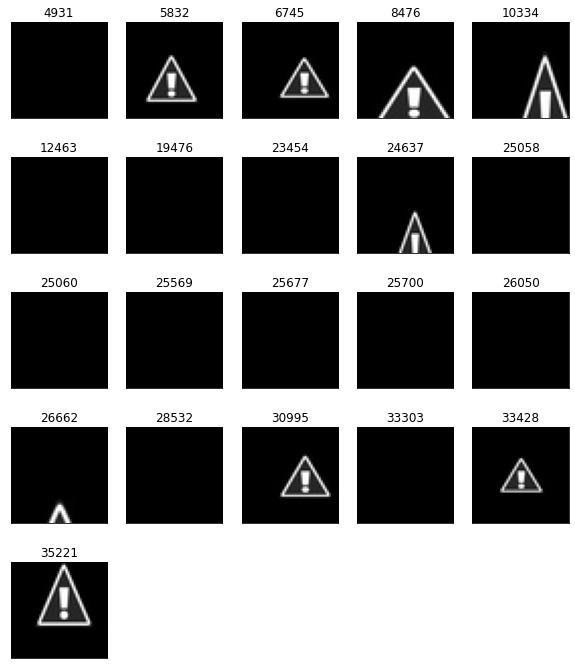

In [ ]:
plt.rc('image', cmap='gray')
plt.figure(figsize=(10, 3*len(black_KNN_hist_idx)//5))
#start = 300
for k in range(len(black_KNN_hist_idx)):
    plt.subplot(len(black_KNN_hist_idx)//5+1,5,k+1)
    ax = plt.gca()
    ax.set_title(black_KNN_hist_idx[k])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X[black_KNN_hist_idx[k],:].reshape(48,48))

Print detected 'letter' images
$\Rightarrow$ Detected 15 images

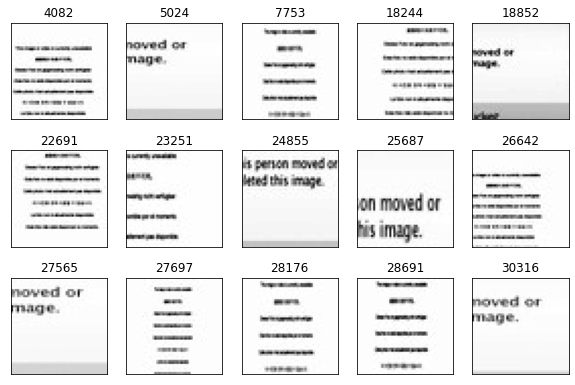

In [ ]:
plt.rc('image', cmap='gray')
plt.figure(figsize=(10, 3*len(letter_KNN_hist_idx)//5))
#start = 300
for k in range(len(letter_KNN_hist_idx)):
    plt.subplot(len(letter_KNN_hist_idx)//5+1,5,k+1)
    ax = plt.gca()
    ax.set_title(letter_KNN_hist_idx[k])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X[letter_KNN_hist_idx[k],:].reshape(48,48))

# New Section

Print detected 'loading' images
$\Rightarrow$ Detected 11 images

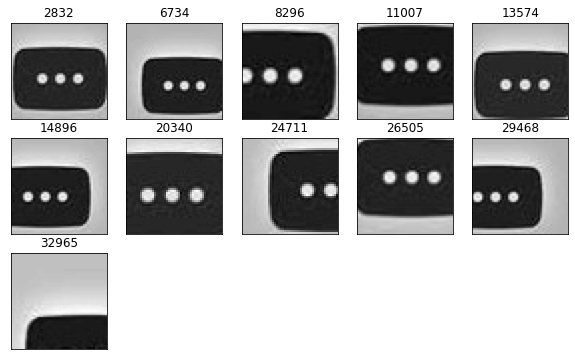

In [ ]:
plt.rc('image', cmap='gray')
plt.figure(figsize=(10, 3*len(loading_KNN_hist_idx)//5))
#start = 300
for k in range(len(loading_KNN_hist_idx)):
    plt.subplot(len(loading_KNN_hist_idx)//5+1,5,k+1)
    ax = plt.gca()
    ax.set_title(loading_KNN_hist_idx[k])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X[loading_KNN_hist_idx[k],:].reshape(48,48))

Print detected 'cartoon' images
$\Rightarrow$ Detected 193 images

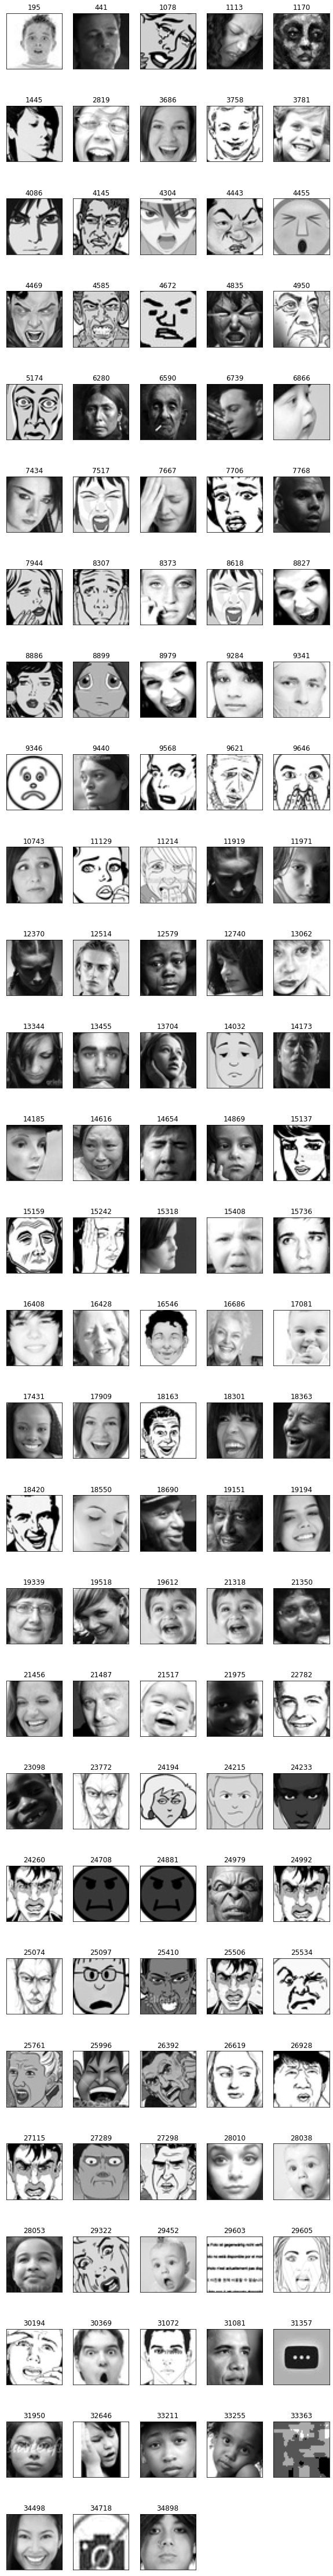

In [ ]:
plt.rc('image', cmap='gray')
plt.figure(figsize=(10, 3*len(cartoon_KNN_hist_idx)//5))
#start = 300
for k in range(len(cartoon_KNN_hist_idx)):
    plt.subplot(len(cartoon_KNN_hist_idx)//5+1,5,k+1)
    ax = plt.gca()
    ax.set_title(cartoon_KNN_hist_idx[k])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X[cartoon_KNN_hist_idx[k],:].reshape(48,48))

In [ ]:
#Indexes of images that are not faces
#loading_KNN_hist_idx
#black_KNN_hist_idx
#letter_KNN_hist_idx

In [ ]:
# Combine all the above indices and remove from dataset
# Remove if duplicated indices exists
#removal_index = list(set(loading_KNN_hist_idx) | set(black_KNN_hist_idx) | set(letter_KNN_hist_idx))
#removed_count = len(removal_index)
#print(len(removal_index))
#print(X.shape[0])
#print("We will be removing %d data out of total %d, which is %.2f%% of the data " %(len(removal_index), X.shape[0], (len(removal_index)/X.shape[0]*100)))
## remove these selected indices of data


#X = np.delete(X, removal_index, 0)
#Y = np.delete(np.array(Y), removal_index, 0).tolist()
#Z = np.delete(np.array(Z), removal_index, 0).tolist()

#happy_set, sad_set, fear_set, surprise_set, neutral_set, angry_set, disgust_set = create_category_sets()
#angry_label, black, letters, loading = create_labels_non_facial_img_angry_dataset()

#len(angry_label)


#### Letter image detection
Using KNN for Fourier transformed images.

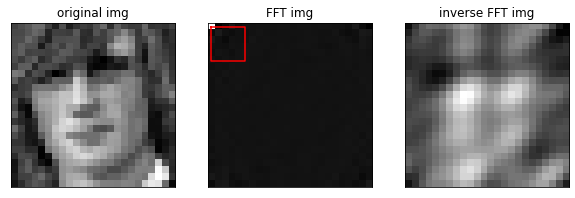

In [ ]:
# example of FFT
from scipy import fftpack
plt.rc('image', cmap='gray')
plt.figure(figsize=(10, 30))
# pick a random image
ran_num = np.random.randint(X.shape[0])
example_img = cv2.resize(X[ran_num,:].reshape(48,48),(24,24)) # resize the img to 24x24(1/4 size of the original)
# plotting original image
plt.subplot(1,3,1)
ax = plt.gca()
ax.set_title('original img')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.imshow(example_img)

# Fourier transform the image
example_fft = fftpack.fft2(example_img)
# plotting original image
plt.subplot(1,3,2)
ax = plt.gca()
ax.set_title('FFT img')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.imshow(example_fft.real)
plt.plot([0,5,5,0,0], [0,0,5,5,0], color = 'red')

# Take only 5x5 of the FFT matrix and make the rest to 0
# It has an effect of Low Pass Filtering
example_fft[5:,:] = 0
example_fft[:,5:] = 0

# Inverse Fourier transform the 5x5 matrix3
example_ifft = np.fft.ifft2(example_fft)
plt.subplot(1,3,3)
ax = plt.gca()
ax.set_title('inverse FFT img')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.imshow(example_ifft.real)

In [ ]:
## Convert images to Fourier transformed frequency domain
## define variables to save Fourier transformed 'Angry_set', and 'X'(Whole dataset)
angry_FFT = []
X_FFT = []

## convert angry_set data
for i in range(angry_set.shape[0]):
    img_fft = fftpack.fft2(cv2.resize(angry_set[i,:].reshape(48,48),(24,24)))
    angry_FFT.append((img_fft.real[:5,:5]).flatten()) # only take 5x5 of the FFT transformed data
    
angry_FFT = np.array(angry_FFT)

## convert the whole data set X
for i in range(X.shape[0]):
    img2_fft = fftpack.fft2(cv2.resize(X[i,:].reshape(48,48),(24,24)))
    X_FFT.append((img2_fft.real[:5,:5]).flatten())

X_FFT = np.array(X_FFT)

Training and predict 'letter' images

In [ ]:
filters_FFT = KNeighborsClassifier(n_neighbors=1)
filters_FFT.fit(angry_FFT, angry_label)
prediction = filters_FFT.predict(X_FFT)
letter_FFT_idx = []
black_FFT_idx = []
loading_FFT_idx = []
cartoon_FFT_idx= []
i=0
for label in prediction:
    if label == 'letters':
        letter_FFT_idx.append(i)
    elif label == 'black':
        black_FFT_idx.append(i)
    elif label == 'loading':
        loading_FFT_idx.append(i)
    elif label == 'cartoon':
        cartoon_FFT_idx.append(i)
    i+=1

print("black",len(black_FFT_idx))
print("letters",len(letter_FFT_idx))
print("loading",len(loading_FFT_idx))
print("cartoon",len(cartoon_FFT_idx))

black 16
letters 27
loading 27
cartoon 178


Print detected 'black' images  ⇒  Detected 16 images

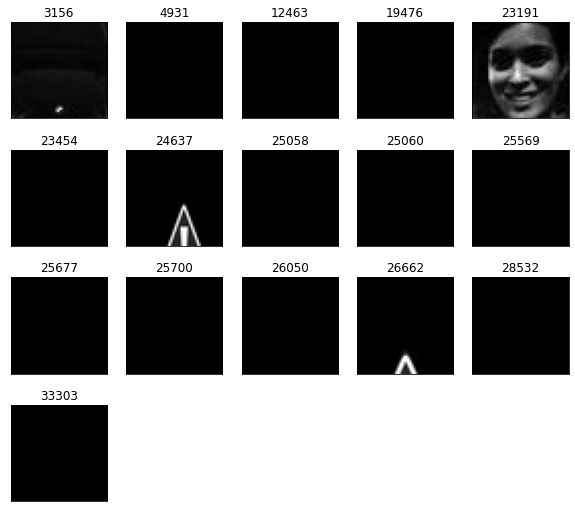

In [ ]:
plt.rc('image', cmap='gray')
plt.figure(figsize=(10, 3*len(black_FFT_idx)//5))

for k in range(len(black_FFT_idx)):
    plt.subplot(len(black_FFT_idx)//5+1,5,k+1)
    ax = plt.gca()
    ax.set_title(black_FFT_idx[k])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X[black_FFT_idx[k],:].reshape(48,48))
plt.show()

Print detected 'letter' images 
$\Rightarrow$ Detected 27 images

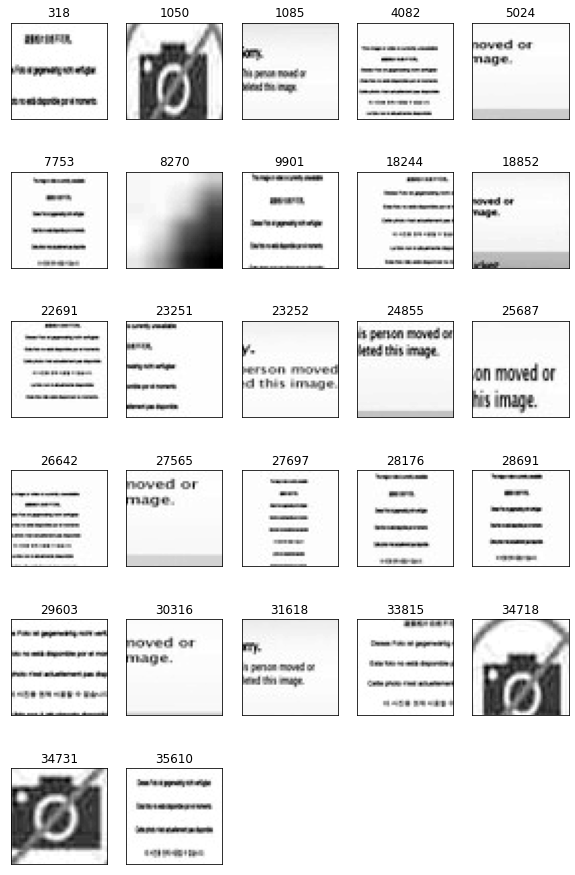

In [ ]:
plt.rc('image', cmap='gray')
plt.figure(figsize=(10, 3*len(letter_FFT_idx)//5))

for k in range(len(letter_FFT_idx)):
    plt.subplot(len(letter_FFT_idx)//5+1,5,k+1)
    ax = plt.gca()
    ax.set_title(letter_FFT_idx[k])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X[letter_FFT_idx[k],:].reshape(48,48))
plt.show()

Print detected 'loading' images  ⇒  Detected 27 image

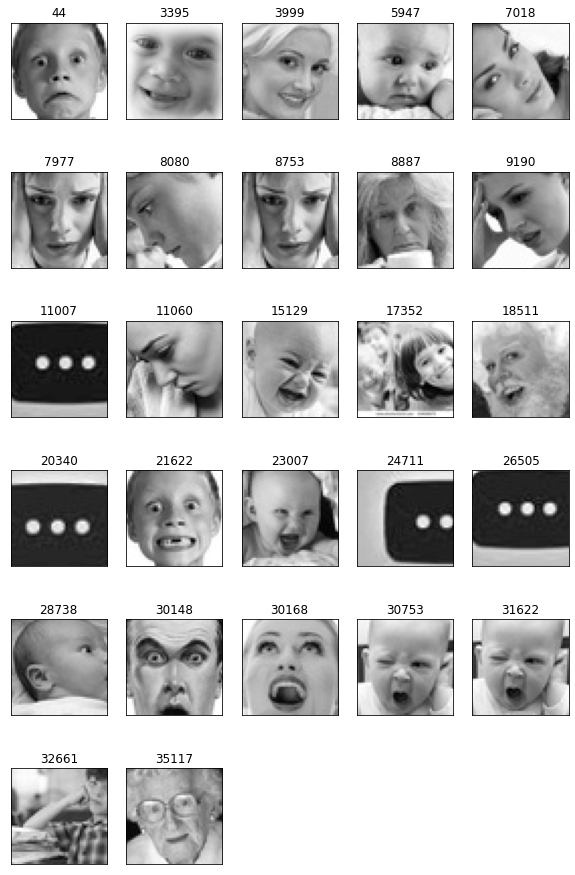

In [ ]:
plt.rc('image', cmap='gray')
plt.figure(figsize=(10, 3*len(loading_FFT_idx)//5))

for k in range(len(loading_FFT_idx)):
    plt.subplot(len(loading_FFT_idx)//5+1,5,k+1)
    ax = plt.gca()
    ax.set_title(loading_FFT_idx[k])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X[loading_FFT_idx[k],:].reshape(48,48))
plt.show()

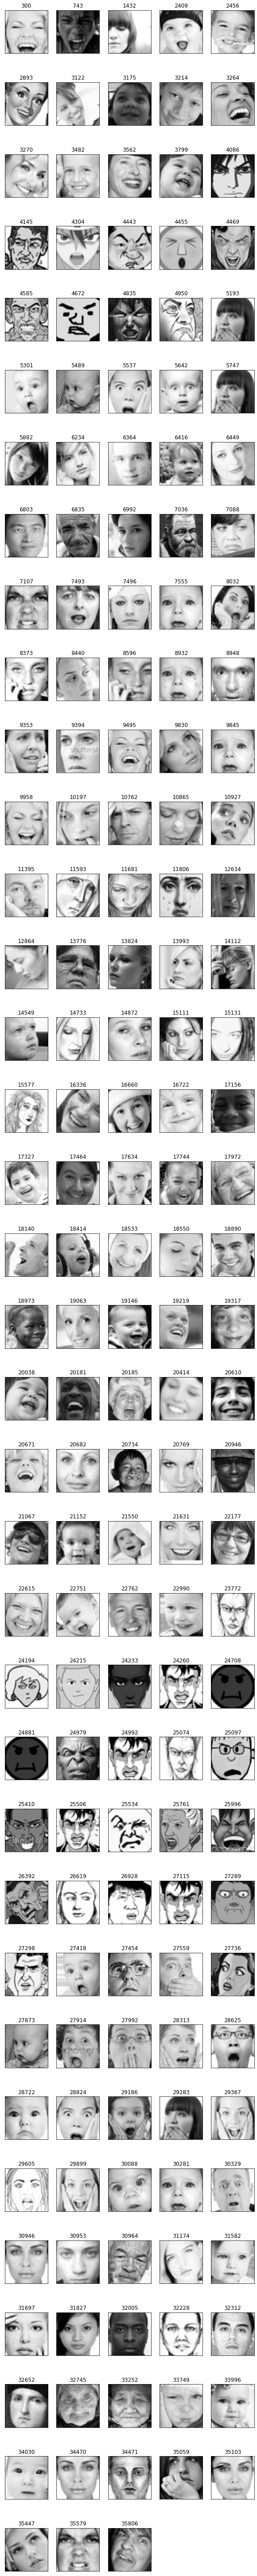

In [ ]:
plt.rc('image', cmap='gray')
plt.figure(figsize=(10, 3*len(cartoon_FFT_idx)//5))

for k in range(len(cartoon_FFT_idx)):
    plt.subplot(len(cartoon_FFT_idx)//5+1,5,k+1)
    ax = plt.gca()
    ax.set_title(cartoon_FFT_idx[k])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X[cartoon_FFT_idx[k],:].reshape(48,48))
plt.show()

#### Black image detection
Using KMean for histogram of images

In [ ]:
# made same 10 clusters
km = KMeans(n_clusters=10,
           #init='random',
           init='k-means++',
           n_init=12,
           max_iter=300,
           tol=1e-04,
           random_state=0)

# predict k-means classes for histogram data
y_km_hist = km.fit_predict(X_hist)

# print clusters and the number of data in a cluster
unique, counts = np.unique(y_km_hist, return_counts=True)
dict(zip(unique, counts))

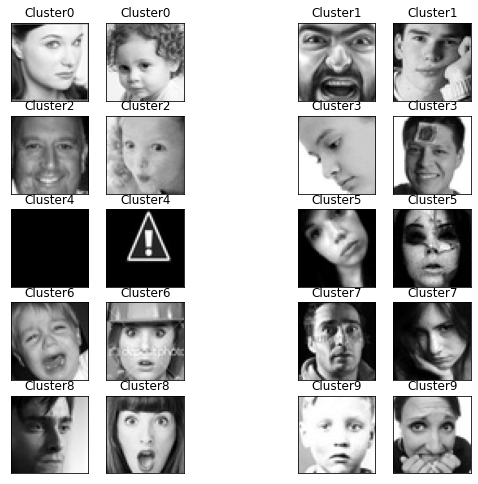

In [ ]:
plt.rc('image', cmap='gray')
plt.figure(figsize=(10, 10))
#start = 300
for k in range(10):
    y_km_idx = np.argwhere(y_km_hist == k)
    plt.subplot(6,6,3*k+1)
    ax = plt.gca()
    ax.set_title('Cluster'+str(k))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    idx = np.random.randint(0, len(y_km_idx))
    plt.imshow(X[y_km_idx[idx][0],:].reshape(48,48))
    
    plt.subplot(6,6,3*k+2)
    ax = plt.gca()
    ax.set_title('Cluster'+str(k))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    idx = np.random.randint(0, len(y_km_idx))
    plt.imshow(X[y_km_idx[idx][0],:].reshape(48,48))

**Cluster #4 shows the black images** $\Rightarrow$



/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


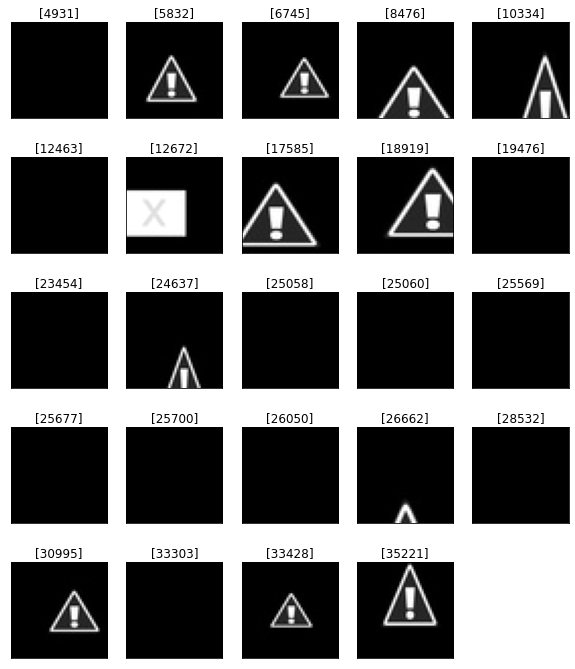

In [ ]:
# save indices for cluster 4
y_km_hist_idx = np.argwhere(y_km_hist==4)
#print(y_km_hist_idx)
# show all images in cluster 4
plt.rc('image', cmap='gray')
##y_km_hist_idx = np.argwhere(y_km==unique[counts==24][0]) # black images
plt.figure(figsize=(10, 3*y_km_hist_idx.shape[0]//6))
for k in range(y_km_hist_idx.shape[0]):
#for k in range(100):
    plt.subplot(y_km_hist_idx.shape[0]//5+1,5,k+1)
    ax = plt.gca()
    ax.set_title(y_km_hist_idx[k])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X[y_km_hist_idx[k],:].reshape(48,48))

In [ ]:
# The 'y_km_hist_idx' has nested list 
# below function will flatten the nested structure
def flattenList(nestedList):
    # check if list is empty
    if not(bool(nestedList)):
        return nestedList
  
     # to check instance of list is empty or not
    if isinstance(nestedList[0], list):
  
        # call function with sublist as argument
        return flattenList(*nestedList[:1]) + flattenList(nestedList[1:])
  
    # call function with sublist as argument
    return nestedList[:1] + flattenList(nestedList[1:])

filter_black = flattenList(y_km_hist_idx.tolist())
print(filter_black)

[4931, 5832, 6745, 8476, 10334, 12463, 12672, 17585, 18919, 19476, 23454, 24637, 25058, 25060, 25569, 25677, 25700, 26050, 26662, 28532, 30995, 33303, 33428, 35221]



### DB scan : Duplicated images

#### DB scan with raw image

In [ ]:
# Tried to cluster with DB scan
db = DBSCAN(eps=3.0, min_samples=2, metric='euclidean')
y_db = db.fit_predict(X)

unique, counts = np.unique(y_db, return_counts=True)
dict(zip(unique, counts))
# Found a lot of duplicated images


# Histogram of duplicated images
# Mostly 2 images duplicated (probably one for the 'train' and one for the 'test')
# But there are 3 or more duplicated images
np.histogram(counts[1:])

(array([1302,  143,   44,   15,    4,    7,    0,    0,    0,    1]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]))

We will remove all the duplicated images
Below are some sample images that are duplicate, in some cases more than once

1516
(2, 1) 0
(3, 1) 12
(4, 1) 43
(5, 1) 226
(6, 1) 56


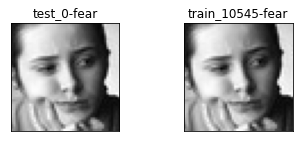

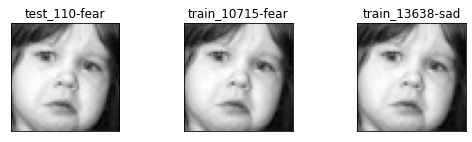

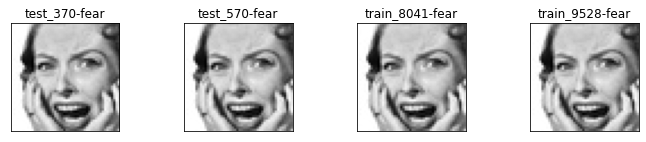

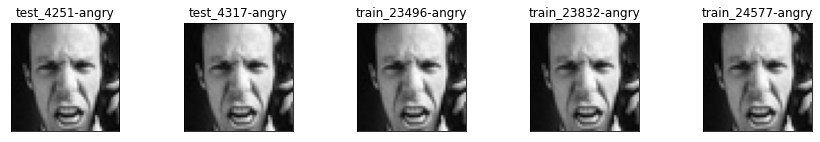

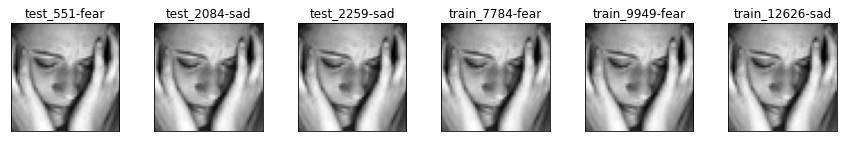

In [ ]:
num_c = unique.shape[0]-1
print(num_c)
y_db_array = []
for clusters in range(num_c):
    y_db_array.append(np.argwhere(y_db == clusters))

#for idx in y_db_array[i]:
#    dup_index.append(idx[0])
    
plt.rc('image', cmap='gray')
cluster = -1

#Pick a cluster with 2 images
for i in range(num_c):
    if y_db_array[i].shape[0] == 2:
        print(y_db_array[i].shape, i)
        cluster = i
        break

fig_dim = y_db_array[cluster].shape[0]
plt.figure(figsize=(15, 2))
#start = 0
for i in range(fig_dim):
    plt.subplot(1, 5, i+1)
    ax = plt.gca()
    #ax.set_title(y_db_array[cluster][i])
    num = y_db_array[cluster][i][0]
    ax.set_title(Z[num].split('/')[0]+"_"+str(num)+"-"+Z[num].split('/')[1])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X[y_db_array[cluster][i],:].reshape(48,48))

#Pick a cluster with 3 images
for i in range(num_c):
    if y_db_array[i].shape[0] == 3:
        print(y_db_array[i].shape, i)
        cluster = i
        break

fig_dim = y_db_array[cluster].shape[0]
plt.figure(figsize=(15, 2))
#start = 0
for i in range(fig_dim):
    plt.subplot(1, 5, i+1)
    ax = plt.gca()
    #ax.set_title(y_db_array[cluster][i])
    num = y_db_array[cluster][i][0]
    ax.set_title(Z[num].split('/')[0]+"_"+str(num)+"-"+Z[num].split('/')[1])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X[y_db_array[cluster][i],:].reshape(48,48))

#Pick a cluster with 4 images
for i in range(num_c):
    if y_db_array[i].shape[0] == 4:
        print(y_db_array[i].shape, i)
        cluster = i
        break

fig_dim = y_db_array[cluster].shape[0]
plt.figure(figsize=(15, 2))
#start = 0
for i in range(fig_dim):
    plt.subplot(1, 5, i+1)
    ax = plt.gca()
    #ax.set_title(y_db_array[cluster][i])
    num = y_db_array[cluster][i][0]
    ax.set_title(Z[num].split('/')[0]+"_"+str(num)+"-"+Z[num].split('/')[1])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X[y_db_array[cluster][i],:].reshape(48,48))

#Pick a cluster with 5 images
for i in range(num_c):
    if y_db_array[i].shape[0] == 5:
        print(y_db_array[i].shape, i)
        cluster = i
        break

fig_dim = y_db_array[cluster].shape[0]
plt.figure(figsize=(15, 2))
#start = 0
for i in range(fig_dim):
    plt.subplot(1, 5, i+1)
    ax = plt.gca()
    #ax.set_title(y_db_array[cluster][i])
    num = y_db_array[cluster][i][0]
    ax.set_title(Z[num].split('/')[0]+"_"+str(num)+"-"+Z[num].split('/')[1])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X[y_db_array[cluster][i],:].reshape(48,48))

#Pick a cluster with 6 images
for i in range(num_c):
    if y_db_array[i].shape[0] == 6:
        print(y_db_array[i].shape, i)
        cluster = i
        break

fig_dim = y_db_array[cluster].shape[0]
plt.figure(figsize=(15, 2))
#start = 0
for i in range(fig_dim):
    plt.subplot(1, 6, i+1)
    ax = plt.gca()
    #ax.set_title(y_db_array[cluster][i])
    num = y_db_array[cluster][i][0]
    ax.set_title(Z[num].split('/')[0]+"_"+str(num)+"-"+Z[num].split('/')[1])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X[y_db_array[cluster][i],:].reshape(48,48))

** Finding indices for the duplicated images **

In [ ]:
dup_index = []
for i in range(len(y_db_array)):
     
  # remove all cross labelled images
  # Keep one Single labelled case
    if np.unique([Y[n[0]] for n in y_db_array[i]]).shape[0] > 1: # In Cross-labeled cases, delete all
        for idx in y_db_array[i]:
            dup_index.append(idx[0])
        #print(i)
    elif np.unique([Y[n[0]] for n in y_db_array[i]]).shape[0] == 1: # In Single-labeled cases, retain one
        j = len(y_db_array[i])   
        x = 0 
        for idx in y_db_array[i]:
            x = x + 1
            if x < j:
               dup_index.append(idx[0])


In [ ]:
print(dup_index)

[5, 6, 11, 13, 17, 18, 20, 24, 29, 31, 32, 39, 9353, 42, 45, 47, 53, 55, 59, 7205, 66, 67, 70, 775, 76, 334, 785, 7752, 78, 389, 8534, 8585, 79, 8219, 80, 7559, 82, 83, 818, 85, 8851, 86, 8954, 89, 92, 93, 97, 98, 100, 101, 103, 117, 119, 122, 124, 8649, 126, 131, 141, 143, 7629, 148, 504, 7497, 149, 576, 150, 777, 157, 161, 162, 201, 163, 166, 170, 174, 177, 188, 198, 199, 200, 205, 208, 210, 7689, 7837, 212, 219, 220, 221, 712, 7204, 7337, 226, 231, 8884, 232, 686, 9457, 28430, 31743, 234, 235, 7264, 236, 240, 640, 7306, 7887, 242, 244, 252, 255, 738, 8866, 256, 7585, 257, 260, 7959, 262, 263, 265, 7526, 272, 277, 278, 279, 284, 285, 290, 293, 456, 9700, 303, 306, 307, 310, 321, 323, 324, 326, 327, 338, 341, 18491, 349, 350, 353, 568, 360, 8186, 364, 9370, 365, 366, 367, 369, 374, 9184, 9377, 379, 381, 384, 385, 9652, 392, 393, 394, 395, 396, 400, 403, 404, 406, 408, 413, 418, 421, 422, 522, 615, 431, 7841, 436, 437, 439, 442, 7690, 450, 457, 7912, 459, 465, 467, 7334, 7617, 8763, 47

# Data Preprocessing

In this section of the python notebook, we will remove all non-facial images and duplicates that were identified under EDA and augment the data so the training data is the same across each class. We will also standardize and create mini train and test datasets.


## Data Filtering

From above detection for the non-facial images and the duplicated images, we will remove selected images.

# New Section

In [ ]:
# Combine all the removal indices (3 category non-facial images + duplicated images)
# Remove if duplicated indices exists
removal_index = list(set(loading_KNN_hist_idx + black_KNN_hist_idx + letter_KNN_hist_idx + black_FFT_idx + letter_FFT_idx + filter_black + dup_index ))

In [ ]:
print(len(removal_index))
print(X.shape[0])
print("We are removing %d images out of total %d, which is %.2f%% of the data " %(len(removal_index), X.shape[0], (len(removal_index)/X.shape[0]*100)))

1962
35887
We are removing 1962 images out of total 35887, which is 5.47% of the data 


In [ ]:
## Filtering Data
## remove these selected indices of data
X_filter = np.delete(X, removal_index, 0)
Y_filter = np.delete(np.array(Y), removal_index, 0).tolist()
Z_filter = np.delete(np.array(Z), removal_index, 0).tolist()

In [ ]:
def detect_front_face(img):
    dim = (img.shape[0], img.shape[1])
    resize = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    resize = np.array(resize, dtype='uint8')

    # Detect the faces
    faces = face_classifier.detectMultiScale(resize, 1.03, 6) ##1.0485258, 6)
    # print(faces)
    if len(faces) == 1:
        return True
    return False

In [ ]:
xml_files = ['haarcascade_frontalface_default.xml', 'haarcascade_frontalface_alt.xml', 'haarcascade_frontalface_alt2.xml','haarcascade_frontalface_alt_tree.xml']
not_front_face_haar_idx = []
valid_front_face_haar_idx = []
for xml_file in xml_files:
    xml_file_path = './drive/MyDrive/281/XML/' + xml_file
    print(xml_file_path)
    face_classifier = cv2.CascadeClassifier(xml_file_path)
    for i in range(X_filter.shape[0]):
        img = X_filter[i,:].reshape(48,48)
        if not detect_front_face(img):
            not_front_face_haar_idx.append(i)
        else:
            valid_front_face_haar_idx.append(i)



./drive/MyDrive/281/XML/haarcascade_frontalface_default.xml
./drive/MyDrive/281/XML/haarcascade_frontalface_alt.xml
./drive/MyDrive/281/XML/haarcascade_frontalface_alt2.xml
./drive/MyDrive/281/XML/haarcascade_frontalface_alt_tree.xml


In [ ]:
print(len(not_front_face_haar_idx))
print(len(valid_front_face_haar_idx))

72955
62745


In [ ]:
# Frontal faces would only be those where an image was tagged as frontal by at least one of the haar frontal face classifiers 
not_front_face_haar_idx = list(set(not_front_face_haar_idx))
print(len(not_front_face_haar_idx))
valid_front_face_haar_idx = list(set(valid_front_face_haar_idx))
print(len(valid_front_face_haar_idx))
#not_front_face_haar_idx = list(np.setdiff1d(not_front_face_haar_idx, valid_front_face_haar_idx))
#print(len(not_front_face_haar_idx))


28479
21696


In [ ]:
print(len(not_front_face_haar_idx))
print(X_filter.shape[0])
print("We may be removing %d images out of total %d, which is %.2f%% of the data " %(len(not_front_face_haar_idx), X_filter.shape[0], (len(not_front_face_haar_idx)/X_filter.shape[0]*100)))

28479
33925
We may be removing 28479 images out of total 33925, which is 83.95% of the data 


In [ ]:
#X_filter = X_filter1
#Y_filter = Y_filter1
#Z_filter = Z_filter1

In [ ]:
print(not_front_face_haar_idx)

[0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 62, 63, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 85, 86, 87, 88, 90, 92, 93, 94, 95, 96, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 177, 178, 179, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,

./drive/MyDrive/281/XML/haarcascade_frontalface_default.xml
./drive/MyDrive/281/XML/haarcascade_frontalface_alt.xml
True
./drive/MyDrive/281/XML/haarcascade_frontalface_alt2.xml
True
./drive/MyDrive/281/XML/haarcascade_frontalface_alt_tree.xml


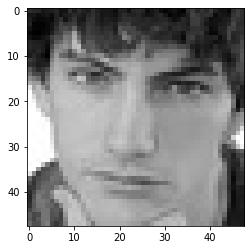

In [ ]:
img = X_filter[30074,:].reshape(48,48)
plt.imshow(img)
for xml_file in xml_files:
    xml_file_path = './drive/MyDrive/281/XML/' + xml_file
    print(xml_file_path)
    face_classifier = cv2.CascadeClassifier(xml_file_path)
    if detect_front_face(img):
        print("True")


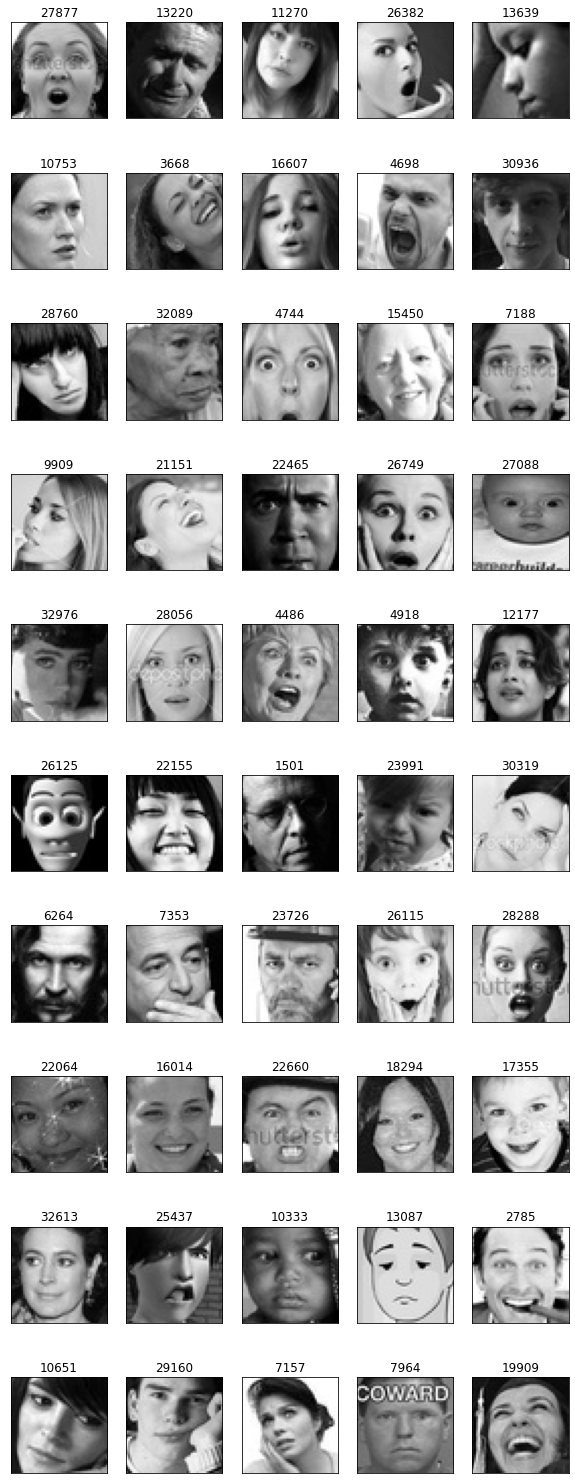

In [ ]:
# print 50 images from this list that is marked for removal
not_front_face_haar_50_idx = random.sample(not_front_face_haar_idx, 50)

plt.rc('image', cmap='gray')
plt.figure(figsize=(10, 3*len(not_front_face_haar_50_idx)//5))
i = 0
for k in not_front_face_haar_50_idx:
    plt.subplot(len(not_front_face_haar_50_idx)//5+1,5,i+1)
    ax = plt.gca()
    ax.set_title(k)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X_filter[k,:].reshape(48,48))
    i = i+1

In [ ]:
def detect_front_facedlib(img):
    dim = (img.shape[0], img.shape[1])
    resize = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    resize = np.array(resize, dtype='uint8')
    faces = detector(resize, 1)
    if len(faces) == 1:
        return True
    return False


In [ ]:
not_front_face_dlib_idx = []
valid_front_face_dlib_idx = []
detector = dlib.get_frontal_face_detector()
for i in range(X_filter.shape[0]):
    img = X_filter[i,:].reshape(48,48)
    if not detect_front_facedlib(img):
        not_front_face_dlib_idx.append(i)
    else:
        valid_front_face_dlib_idx.append(i)

In [ ]:
# Frontal faces would be those that are tagged as scuh by the HOG face classifier
not_front_face_dlib_idx = list(set(not_front_face_dlib_idx))
print(len(not_front_face_dlib_idx))
valid_front_face_dlib_idx = list(set(valid_front_face_dlib_idx))
print(len(valid_front_face_dlib_idx))
#not_front_face_dlib_idx = list(np.setdiff1d(not_front_face_dlib_idx, valid_front_face_dlib_idx))
#print(len(not_front_face_dlib_idx))


10542
23383


In [ ]:
print(len(not_front_face_dlib_idx))
print(X_filter.shape[0])
print("We may be removing %d images out of total %d, which is %.2f%% of the data " %(len(not_front_face_dlib_idx), X_filter.shape[0], (len(not_front_face_dlib_idx)/X_filter.shape[0]*100)))

10542
33925
We may be removing 10542 images out of total 33925, which is 31.07% of the data 


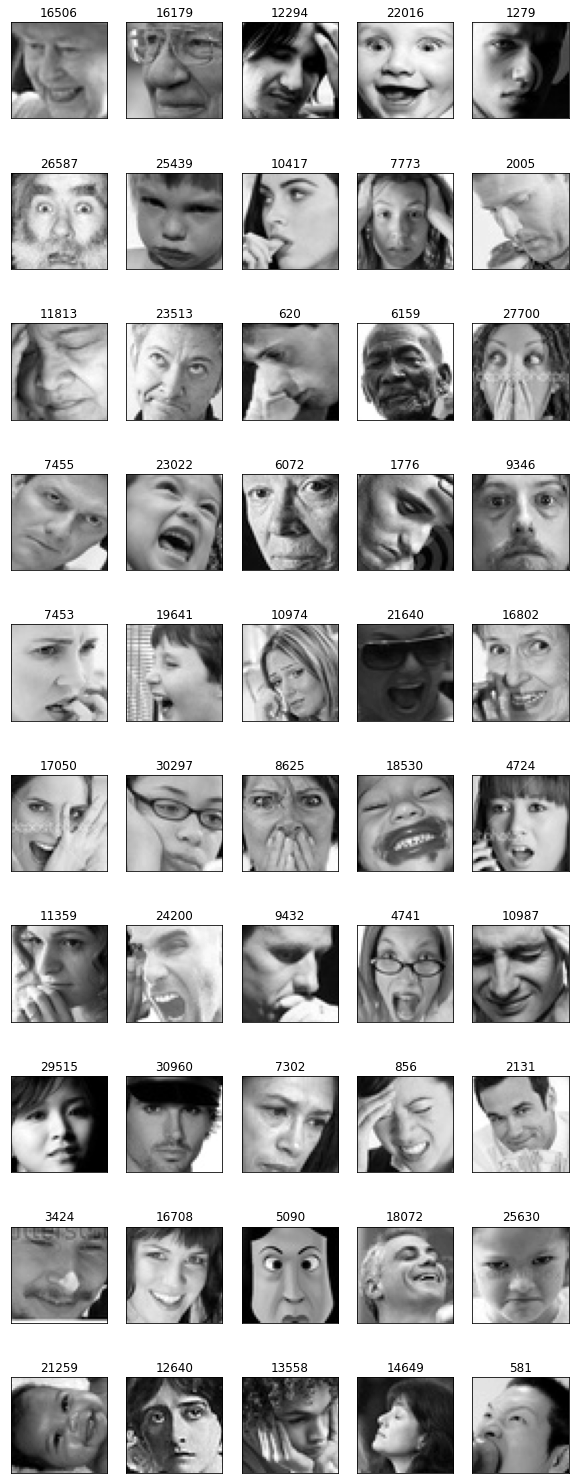

In [ ]:
# print 50 images from this list that is marked for removal
import random
not_front_face_dlib_50_idx = random.sample(not_front_face_dlib_idx, 50)

plt.rc('image', cmap='gray')
plt.figure(figsize=(10, 3*len(not_front_face_dlib_50_idx)//5))
i = 0
for k in not_front_face_dlib_50_idx:
    plt.subplot(len(not_front_face_dlib_50_idx)//5+1,5,i+1)
    ax = plt.gca()
    ax.set_title(k)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X_filter[k,:].reshape(48,48))
    i = i+1

101


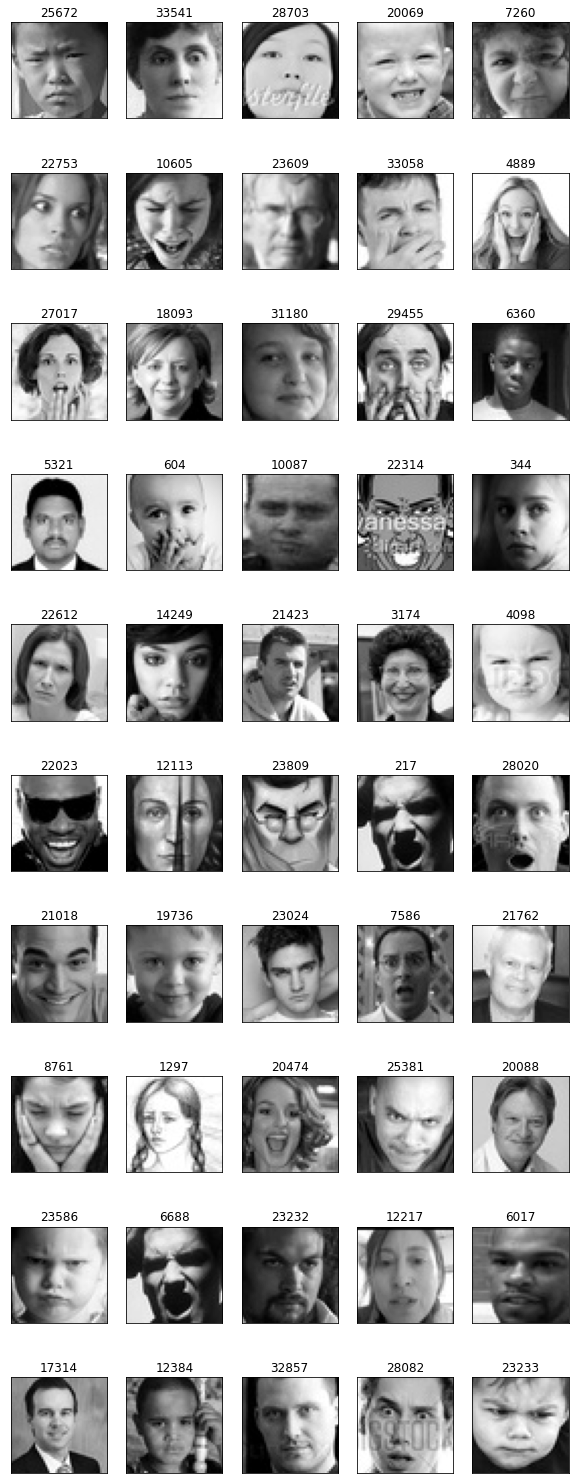

In [ ]:
# in dlib removal list BUT not in haar removal list
not_in_haar_idx = list(np.setdiff1d(not_front_face_dlib_idx, not_front_face_haar_idx))
print(len(not_in_haar_idx))

# print 50 images from this list
import random
not_in_haar_50_idx = random.sample(not_in_haar_idx, 50)

plt.rc('image', cmap='gray')
plt.figure(figsize=(10, 3*len(not_in_haar_50_idx)//5))
i = 0
for k in not_in_haar_50_idx:
    plt.subplot(len(not_in_haar_50_idx)//5+1,5,i+1)
    ax = plt.gca()
    ax.set_title(k)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X_filter[k,:].reshape(48,48))
    i = i+1


18038


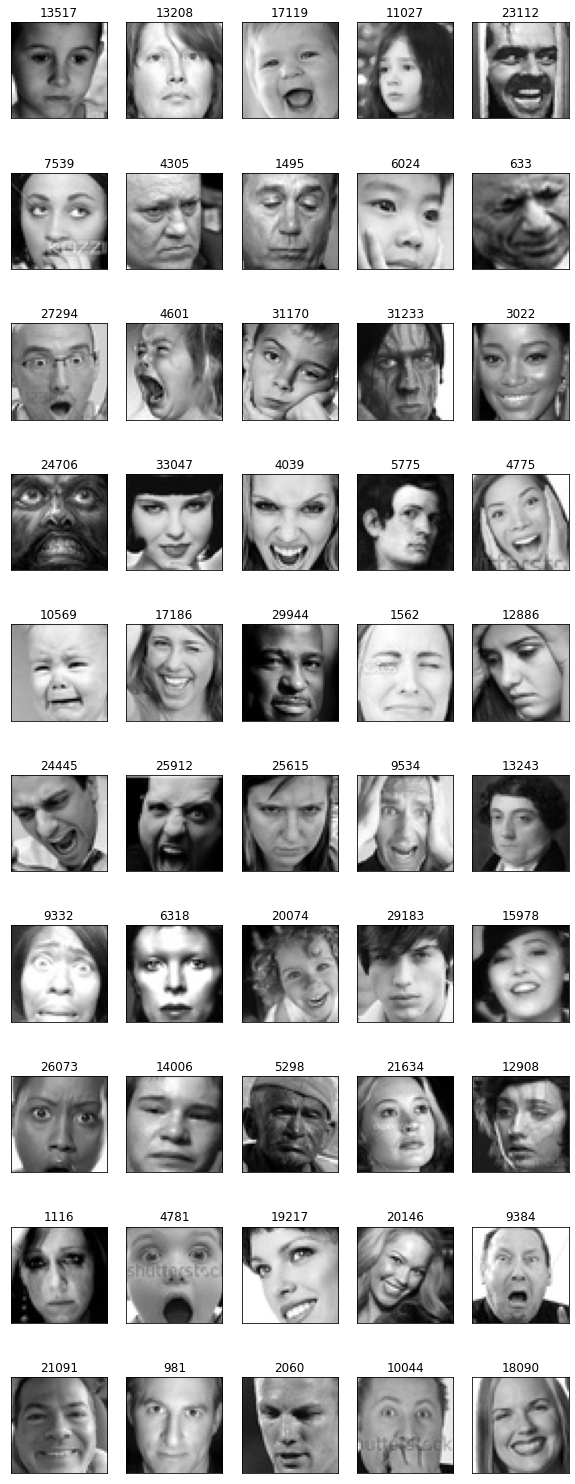

In [ ]:
# in haar removal list BUT not in dlib removal list
not_in_dlib_idx = list(np.setdiff1d(not_front_face_haar_idx, not_front_face_dlib_idx))
print(len(not_in_dlib_idx))

# print 50 images from this list
import random
not_in_dlib_50_idx = random.sample(not_in_dlib_idx, 50)

plt.rc('image', cmap='gray')
plt.figure(figsize=(10, 3*len(not_in_dlib_50_idx)//5))
i = 0
for k in not_in_dlib_50_idx:
    plt.subplot(len(not_in_dlib_50_idx)//5+1,5,i+1)
    ax = plt.gca()
    ax.set_title(k)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X_filter[k,:].reshape(48,48))
    i = i+1

5345


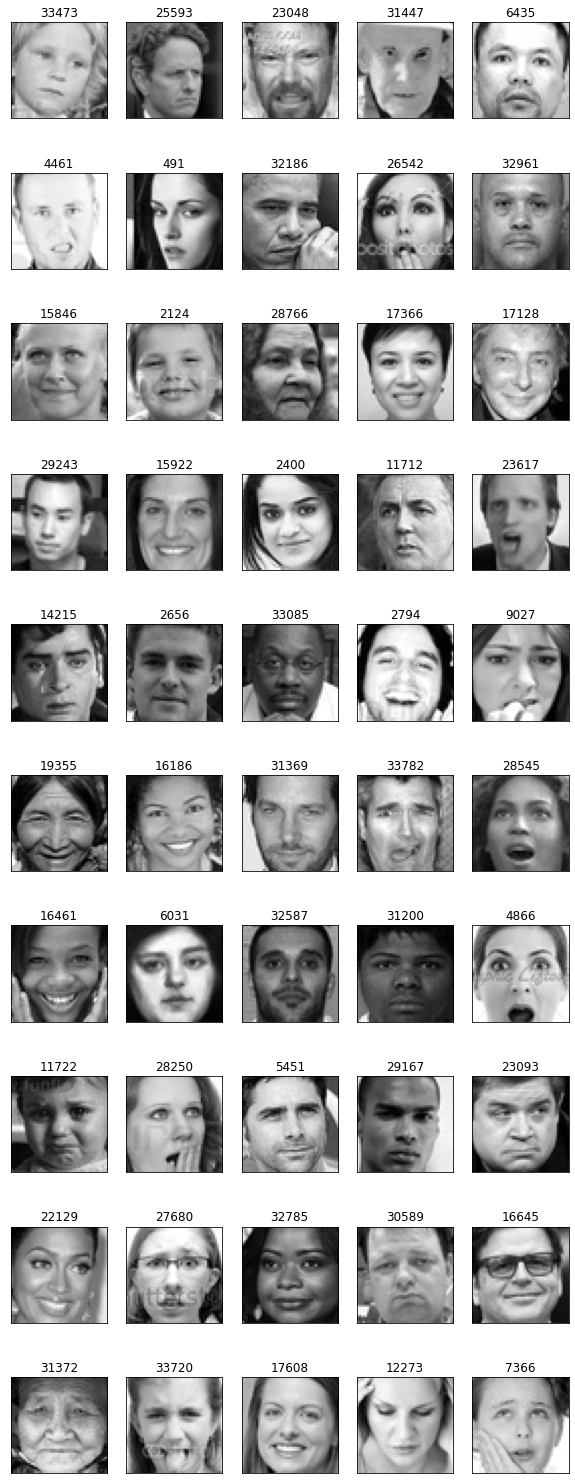

In [ ]:
# print 50 images from the input list that is not in either removal list
input_lst_idx = [i for i in range(X_filter.shape[0])]

valid_input_lst_idx = list(np.setdiff1d(input_lst_idx, not_front_face_dlib_idx+not_front_face_haar_idx))
print(len(valid_input_lst_idx))

# print 50 images from this list
valid_input_lst_50_idx = random.sample(valid_input_lst_idx, 50)

plt.rc('image', cmap='gray')
plt.figure(figsize=(10, 3*len(valid_input_lst_50_idx)//5))
i = 0
for k in valid_input_lst_50_idx:
    plt.subplot(len(valid_input_lst_50_idx)//5+1,5,i+1)
    ax = plt.gca()
    ax.set_title(k)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(X_filter[k,:].reshape(48,48))
    i = i+1


In [ ]:
# remove all images that were not flagged as frontal faces by either face classifiers
removal_index = list(set(not_front_face_haar_idx + not_front_face_dlib_idx))
print(len(removal_index))
keep_idx = list(set(valid_front_face_haar_idx + valid_front_face_dlib_idx))
print(len(keep_idx))
#removal_index = list(np.setdiff1d(removal_index, keep_idx))
print(len(removal_index))


28580
26378
28580


In [ ]:
print(len(removal_index))
print(X_filter.shape[0])
print("We will be removing %d images out of total %d, which is %.2f%% of the data " %(len(removal_index), X_filter.shape[0], (len(removal_index)/X_filter.shape[0]*100)))

28580
33925
We will be removing 28580 images out of total 33925, which is 84.24% of the data 


In [ ]:
## Filtering Data
## remove these selected indices of data
X_filter = np.delete(X_filter, removal_index, 0)
Y_filter = np.delete(np.array(Y_filter), removal_index, 0).tolist()
Z_filter = np.delete(np.array(Z_filter), removal_index, 0).tolist()

In [ ]:
for i in range(X_filter.shape[0]):
    # Save the filtered data to './dataset_filtered/'
    directory = "./drive/MyDrive/281/dataset_filtered_consolidated4/" + Z_filter[i].split("/")[1]
    if not os.path.exists(directory):
        os.makedirs(directory)
    cv2.imwrite("./drive/MyDrive/281/dataset_filtered_consolidated4/"+Z_filter[i].split("/")[1]+"/"+Z_filter[i].split("/")[-1], X_filter[i].reshape(48,48))
    #print("./drive/MyDrive/w281/dataset_filtered/"+Z_filter[i])
    if Z_filter[i].split("/")[1] != Y_filter[i]: # check if mislabeled case exists
        print("fault")

In [ ]:
print(X_filter.shape)
print(len(list(set(removal_index))))

(7307, 2304)
28580


In [ ]:
from google.colab import files
output_file_name = 'Archive_filtered4.zip'
os.system('zip -r {} {}'.format(output_file_name, './drive/MyDrive/281/dataset_filtered_consolidated4/'))
files.download(output_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
## does not sound right !!
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
for emotion in emotions:
    img_num = len(os.listdir('./drive/MyDrive/281/dataset_filtered_consolidated4/' + emotion))
    print(emotion, ':', img_num, 'images') 

angry : 681 images
disgust : 447 images
fear : 543 images
happy : 1750 images
neutral : 2460 images
sad : 720 images
surprise : 706 images


Cleanup all variables used so far

In [ ]:
X, Y, Z = [],[],[]
black, letters, loading, cartoon = [],[],[],[]
hist_filt, letter_KNN_hist_idx, black_KNN_hist_idx, loading_KNN_hist_idxcartoon_KNN_hist_idx = [],[],[],[]
angry_FFT, X_FFT, filters_FFT, letter_FFT_idx, black_FFT_idx, loading_FFT_idx, cartoon_FFT_idx  = [],[],[],[],[],[],[]
y_km_hist, unique, counts, y_km_hist_idx, filter_black, y_db, y_db_array = [],[],[],[],[],[],[]
removal_index, not_front_face_haar_idx, not_front_face_dlib_idx, valid_front_face_haar_idx, valid_front_face_dlib_idx= [], [], [], [], []